In [5]:
import bioframe as bf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import pearsonr, spearmanr, mannwhitneyu, fisher_exact
from scipy.special import softmax
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

from gpn.utils import load_table

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading GPN probabilities

In [4]:
MODEL = "gonzalobenegas/gpn-brassicales"

nucleotides = list("ACGT")

d = Path(f"output/whole_genome")
pred = pd.read_parquet(d / "positions.parquet")
# perplexity of seeing that particular nucleotide
pred.loc[:, nucleotides] = 1 / softmax(pd.read_parquet(d / "logits" / f"{MODEL}.parquet")[nucleotides].values, axis=1)
pred = pred[pred.chrom=="5"]
pred.pos -= 1  # 1-based -> 0-based
pred = pred.set_index(["chrom", "pos"], drop=False)
pred

pos chrom          A          C          G           T
chrom pos                                                                  
5     256            256     5   3.672214   2.236321  18.842581    4.396562
      257            257     5   3.150046   6.094252   6.401055    2.760669
      258            258     5   1.538006  11.135742   8.215002    7.231818
      259            259     5   2.029547   7.835488  17.534660    3.099574
      260            260     5   2.975541  10.430225   9.423880    2.164793
...                  ...   ...        ...        ...        ...         ...
      26975241  26975241     5   6.249290   7.078860  15.311447    1.578767
      26975242  26975242     5   5.611965  35.983200   1.454657    9.383389
      26975243  26975243     5   5.272018  28.162104   5.208204    1.715837
      26975244  26975244     5  13.716424  85.300064   1.101905  127.358849
      26975245  26975245     5  50.616665   1.177075  95.355019    8.319965

[26954713 rows x 6 columns]

## Loading annotation

In [7]:
annotation = load_table("output/annotation.gtf.gz").query('chrom=="5"')
annotation

,chrom,source,feature,start,end,score,strand,frame,attribute
609890,5,TAIR10,chromosome,0,26975502,.,.,.,"ID=chromosome:5;Alias=Chr5,CP002688.1,NC_003076.8"
609891,5,araport11,ncRNA_gene,1,303,.,+,.,ID=gene:AT5G00730;Name=AT5G00730;biotype=lncRN...
609892,5,araport11,lnc_RNA,1,303,.,+,.,ID=transcript:AT5G00730.1;Parent=gene:AT5G0073...
609893,5,araport11,exon,1,303,.,+,.,Parent=transcript:AT5G00730.1;Name=AT5G00730.1...
609894,5,araport11,gene,994,5156,.,-,.,ID=gene:AT5G01010;Name=AT5G01010;biotype=prote...
...,...,...,...,...,...,...,...,...,...
790416,5,araport11,lnc_RNA,26971388,26971689,.,+,.,ID=transcript:AT5G09955.1;Parent=gene:AT5G0995...
790417,5,araport11,exon,26971388,26971689,.,+,.,Parent=transcript:AT5G09955.1;Name=AT5G09955.1...
790418,5,araport11,ncRNA_gene,26972176,26972644,.,-,.,ID=gene:AT5G09965;Name=AT5G09965;biotype=lncRN...
790419,5,araport11,lnc_RNA,26972176,26972644,.,-,.,ID=transcript:AT5G09965.1;Parent=gene:AT5G0996...


In [8]:
annotation.query('feature=="CDS"')

,chrom,source,feature,start,end,score,strand,frame,attribute
609900,5,araport11,CDS,1387,1459,.,-,0,ID=CDS:AT5G01010.2;Parent=transcript:AT5G01010...
609902,5,araport11,CDS,1571,1646,.,-,0,ID=CDS:AT5G01010.2;Parent=transcript:AT5G01010...
609904,5,araport11,CDS,1744,1780,.,-,0,ID=CDS:AT5G01010.2;Parent=transcript:AT5G01010...
609906,5,araport11,CDS,1913,2007,.,-,1,ID=CDS:AT5G01010.2;Parent=transcript:AT5G01010...
609908,5,araport11,CDS,2104,2181,.,-,0,ID=CDS:AT5G01010.2;Parent=transcript:AT5G01010...
...,...,...,...,...,...,...,...,...,...
790400,5,araport11,CDS,26968557,26969306,.,-,0,ID=CDS:AT5G67630.1;Parent=transcript:AT5G67630...
790407,5,araport11,CDS,26969545,26969670,.,-,2,ID=CDS:AT5G67640.1;Parent=transcript:AT5G67640...
790409,5,araport11,CDS,26969914,26970241,.,-,2,ID=CDS:AT5G67640.1;Parent=transcript:AT5G67640...
790411,5,araport11,CDS,26970311,26970360,.,-,0,ID=CDS:AT5G67640.1;Parent=transcript:AT5G67640...


In [13]:
exons = annotation.query('feature=="exon"').copy()
exons["transcript_id"] = exons.attribute.str.split(";").str[0].str.split(":").str[-1]
exons

,chrom,source,feature,start,end,score,strand,frame,attribute,transcript_id
609893,5,araport11,exon,1,303,.,+,.,Parent=transcript:AT5G00730.1;Name=AT5G00730.1...,AT5G00730.1
609896,5,araport11,exon,994,1225,.,-,.,Parent=transcript:AT5G01010.2;Name=AT5G01010.2...,AT5G01010.2
609899,5,araport11,exon,1372,1459,.,-,.,Parent=transcript:AT5G01010.2;Name=AT5G01010.2...,AT5G01010.2
609901,5,araport11,exon,1571,1646,.,-,.,Parent=transcript:AT5G01010.2;Name=AT5G01010.5...,AT5G01010.2
609903,5,araport11,exon,1744,1780,.,-,.,Parent=transcript:AT5G01010.2;Name=AT5G01010.5...,AT5G01010.2
...,...,...,...,...,...,...,...,...,...,...
790408,5,araport11,exon,26969914,26970241,.,-,.,Parent=transcript:AT5G67640.1;Name=AT5G67640.1...,AT5G67640.1
790410,5,araport11,exon,26970311,26970360,.,-,.,Parent=transcript:AT5G67640.1;Name=AT5G67640.1...,AT5G67640.1
790413,5,araport11,exon,26970443,26970668,.,-,.,Parent=transcript:AT5G67640.1;Name=AT5G67640.1...,AT5G67640.1
790417,5,araport11,exon,26971388,26971689,.,+,.,Parent=transcript:AT5G09955.1;Name=AT5G09955.1...,AT5G09955.1


In [12]:
CDSs = annotation.query('feature=="CDS"').copy()
CDSs["CDS_id"] = CDSs.attribute.str.split(";").str[0].str.split(":").str[-1]
CDSs

,chrom,source,feature,start,end,score,strand,frame,attribute,CDS_id
609900,5,araport11,CDS,1387,1459,.,-,0,ID=CDS:AT5G01010.2;Parent=transcript:AT5G01010...,AT5G01010.2
609902,5,araport11,CDS,1571,1646,.,-,0,ID=CDS:AT5G01010.2;Parent=transcript:AT5G01010...,AT5G01010.2
609904,5,araport11,CDS,1744,1780,.,-,0,ID=CDS:AT5G01010.2;Parent=transcript:AT5G01010...,AT5G01010.2
609906,5,araport11,CDS,1913,2007,.,-,1,ID=CDS:AT5G01010.2;Parent=transcript:AT5G01010...,AT5G01010.2
609908,5,araport11,CDS,2104,2181,.,-,0,ID=CDS:AT5G01010.2;Parent=transcript:AT5G01010...,AT5G01010.2
...,...,...,...,...,...,...,...,...,...,...
790400,5,araport11,CDS,26968557,26969306,.,-,0,ID=CDS:AT5G67630.1;Parent=transcript:AT5G67630...,AT5G67630.1
790407,5,araport11,CDS,26969545,26969670,.,-,2,ID=CDS:AT5G67640.1;Parent=transcript:AT5G67640...,AT5G67640.1
790409,5,araport11,CDS,26969914,26970241,.,-,2,ID=CDS:AT5G67640.1;Parent=transcript:AT5G67640...,AT5G67640.1
790411,5,araport11,CDS,26970311,26970360,.,-,0,ID=CDS:AT5G67640.1;Parent=transcript:AT5G67640...,AT5G67640.1


In [18]:
x = slice(0, -1)
exons.iloc[x]

,chrom,source,feature,start,end,score,strand,frame,attribute,transcript_id
609893,5,araport11,exon,1,303,.,+,.,Parent=transcript:AT5G00730.1;Name=AT5G00730.1...,AT5G00730.1
609896,5,araport11,exon,994,1225,.,-,.,Parent=transcript:AT5G01010.2;Name=AT5G01010.2...,AT5G01010.2
609899,5,araport11,exon,1372,1459,.,-,.,Parent=transcript:AT5G01010.2;Name=AT5G01010.2...,AT5G01010.2
609901,5,araport11,exon,1571,1646,.,-,.,Parent=transcript:AT5G01010.2;Name=AT5G01010.5...,AT5G01010.2
609903,5,araport11,exon,1744,1780,.,-,.,Parent=transcript:AT5G01010.2;Name=AT5G01010.5...,AT5G01010.2
...,...,...,...,...,...,...,...,...,...,...
790406,5,araport11,exon,26969515,26969670,.,-,.,Parent=transcript:AT5G67640.1;Name=AT5G67640.1...,AT5G67640.1
790408,5,araport11,exon,26969914,26970241,.,-,.,Parent=transcript:AT5G67640.1;Name=AT5G67640.1...,AT5G67640.1
790410,5,araport11,exon,26970311,26970360,.,-,.,Parent=transcript:AT5G67640.1;Name=AT5G67640.1...,AT5G67640.1
790413,5,araport11,exon,26970443,26970668,.,-,.,Parent=transcript:AT5G67640.1;Name=AT5G67640.1...,AT5G67640.1


In [23]:
def find_elements(df, keep):
    return df.sort_values("start", ascending=df.strand.iloc[0]=="+").iloc[keep]


def find_splice_donors(exons):
    # all exons in a transcript except the last
    my_exons = exons.groupby("transcript_id", sort=False).apply(lambda df: find_elements(df, slice(None, -1)))
    return pd.DataFrame(
        my_exons.apply(
            lambda e: (e.chrom, e.end, e.end+2) if e.strand=="+" else (e.chrom, e.start-2, e.start),
            axis=1, result_type="expand"
        ).values,
        columns=["chrom", "start", "end"],
    )

# slice(0, 1)
# slice(-1, None)
# slice(1, None)
# slice(None, -1)

find_splice_donors(exons)

,chrom,start,end
0,5,4762,4764
1,5,4549,4551
2,5,4332,4334
3,5,4099,4101
4,5,3924,3926
...,...,...,...
59498,5,26965195,26965197
59499,5,26968555,26968557
59500,5,26970441,26970443
59501,5,26970309,26970311


In [ ]:
# go and check in the genome browser (and in the genome ref)

In [9]:
# want a metric that is normalized by TF length
# so anything that is averaged across positions
from scipy.stats import entropy

# could use multiindex from product chrom,range

def get_gpn(row):
    pred_row = pred.loc[pd.MultiIndex.from_product([[row.chrom], range(row.start, row.end)])]
    if row.strand == "+":
        return pred_row[nucleotides].values
    else:
        return pred_row[nucleotides_c].values[::-1]
    
    
def mean_L2_dist(X, Y):
    return np.linalg.norm(Y-X, axis=1).mean()


def mean_absolute_difference(X, Y):
    return np.mean(np.abs(Y-X))


def mean_kl(P, Q):
    eps = 1e-2
    return entropy(P+eps, Q+eps, base=2, axis=1).mean()


BKGD_DIST = np.array([0.33230, 0.16770, 0.16770, 0.33230])

def calculate_motif_distance(row):
    probs_gpn = get_gpn(row)
    probs_plantfdb = motifs[row.TF]
    probs_bkgd = np.tile(BKGD_DIST, (len(probs_plantfdb), 1))
    #f = mean_kl  # doesn't look very good. also, arbitrary epsilon
    f = mean_absolute_difference
    #f = mean_L2_dist
    return (
        f(probs_plantfdb, probs_gpn), f(probs_plantfdb, probs_bkgd),
    )
    
tfbs["distance"], tfbs["distance_random"] = zip(*tfbs.progress_apply(calculate_motif_distance, axis=1))
tfbs

100%|██████████| 38368/38368 [00:53<00:00, 715.21it/s]
/tmp/ipykernel_2328789/3641246890.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfbs["distance"], tfbs["distance_random"] = zip(*tfbs.progress_apply(calculate_motif_distance, axis=1))
/tmp/ipykernel_2328789/3641246890.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfbs["distance"], tfbs["distance_random"] = zip(*tfbs.progress_apply(calculate_motif_distance, axis=1))


,chrom,start,end,strand,TF,seq,correlation,pvalue,count,distance,distance_random
2,1,1427,1438,+,AT5G67450,AGAGTCAGTGT,0.7447,0.008562,1,0.196203,0.215864
3,1,2981,2995,-,AT5G41570,AGGTTGACTTTTTG,0.5341,0.049120,1,0.187494,0.240161
4,1,4046,4066,+,AT2G01570,GAGAAAACAACAAAGGGAAT,0.5183,0.019210,1,0.206790,0.190061
5,1,7878,7893,-,AT3G61250,TGTGTAGTTGGTGAG,0.5331,0.040730,1,0.197308,0.214207
6,1,7939,7954,-,AT2G41690,CTTCTAGACTGTTGT,0.5292,0.042510,1,0.235991,0.242090
...,...,...,...,...,...,...,...,...,...,...,...
327173,5,26969329,26969350,-,AT3G20310,GCTCTTCTCCCTCCGCCTCAA,0.5279,0.013900,1,0.200057,0.224492
327177,5,26970466,26970481,+,AT3G24050,AAGAAGGTGGCGATG,0.5336,0.040480,1,0.142703,0.255672
327178,5,26970686,26970698,+,AT2G21900,CACAAGTCAAAG,0.5772,0.049400,1,0.195617,0.235175
327179,5,26972170,26972191,+,AT2G40340,AGAGATCAAGTAGGCGGTGAT,0.5114,0.017810,1,0.218235,0.245782


<AxesSubplot: xlabel='distance', ylabel='Count'>

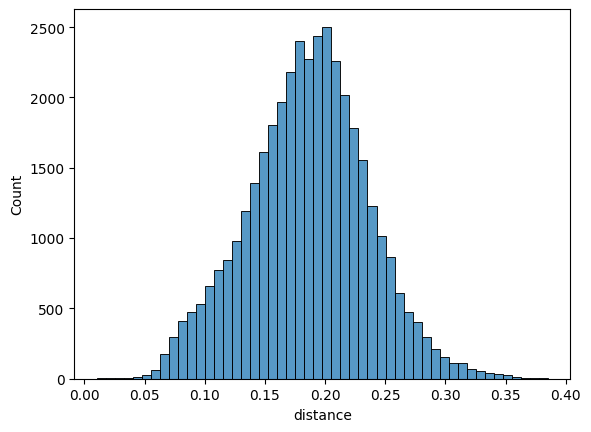

In [10]:
sns.histplot(data=tfbs, x="distance", bins=50)

In [11]:
tfbs["performance"] = tfbs.distance_random-tfbs.distance

/tmp/ipykernel_2328789/154959367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfbs["performance"] = tfbs.distance_random-tfbs.distance


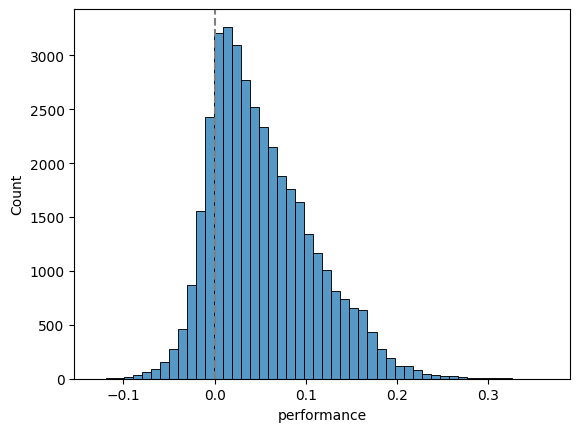

In [12]:
sns.histplot(data=tfbs, x="performance", bins=50)
plt.axvline(0, ls="--", color="gray")

In [13]:
median_performance = tfbs.groupby("TF").performance.median().rename("median_performance")
median_distance = tfbs.groupby("TF").distance.median().rename("median_distance")
median_performance

TF
AT1G01060    0.016948
AT1G01250    0.021607
AT1G01260    0.061642
AT1G01720   -0.017723
AT1G02065   -0.016867
               ...   
AT5G67000    0.018074
AT5G67190    0.019161
AT5G67300   -0.009445
AT5G67450    0.024289
AT5G67580    0.049567
Name: median_performance, Length: 584, dtype: float64

In [14]:
TF_counts_test = tfbs.TF.value_counts().rename("test_counts")
agg_TF = pd.merge(TF_counts_train, TF_counts_test, left_index=True, right_index=True)
agg_TF = pd.merge(agg_TF, median_distance, left_index=True, right_index=True)
agg_TF = pd.merge(agg_TF, median_performance, left_index=True, right_index=True)
agg_TF

,train_counts,test_counts,median_distance,median_performance
AT1G72050,1505,2461,0.170549,0.094744
AT1G49480,773,1242,0.092358,0.148058
AT3G24050,451,736,0.161927,0.093745
AT2G45660,442,742,0.141108,0.050396
AT1G72740,431,682,0.120428,0.140169
...,...,...,...,...
AT5G52170,1,1,0.222050,0.034754
AT4G36780,1,2,0.116480,0.190137
AT1G54330,1,4,0.178025,0.033976
AT5G15830,1,3,0.246614,0.011281
